In [48]:
import numpy as np
import pandas as pd
import scipy.io as sio   ## for loading octave matlab file
import math
from scipy.special import expit #Vectorized sigmoid function
import matplotlib.pyplot as plt
import scipy.optimize #fmin_cg to train neural network


In [49]:
mat_contents = sio.loadmat(r"C:\Users\user\Documents\Machine learning\machine-learning-ex4\ex4\ex4data1.mat")
# training data stored in arrays X, y
X=mat_contents['X']
y=mat_contents['y']          #### taking out X and y from the matrix


m=len(X)

theta_contents = sio.loadmat(r"C:\Users\user\Documents\Machine learning\machine-learning-ex4\ex4\ex4weights.mat")
theta1=theta_contents['Theta1']
theta2=theta_contents['Theta2']
print(theta1.shape)
print(theta2.shape)

(25, 401)
(10, 26)


In [50]:
m,n = X.shape

####% Randomly select 100 data points to display
sel = np.random.choice(X.shape[0], size=100, replace=False)
selected_X=X[sel]

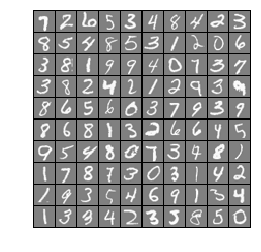

In [51]:
##  FUNCTION TO DISPLAY DATA This function maps each row to a 20 pixel by 20 pixel grayscale image and 
##  displays the images together
def displayData(X, example_width=None):
    # closes previously opened figure. preventing a
    # warning after opening too many figures
    plt.close()
# creates new figure 
    plt.figure()
# Set example_width automatically if not passed in
    if not example_width or not 'example_width' in locals():
        example_width = int(round(math.sqrt(X.shape[1])))
# Gray Image color map 
    plt.set_cmap("gray")
#Compute rows, cols
    m,n = X.shape
    example_height =int(n / example_width)
# Compute number of items to display
    display_rows = int(math.floor(math.sqrt(m)))
    display_cols = int(math.ceil(m / display_rows))
# Between images padding
    pad = 1
# Setup blank display
    display_array = -np.ones((pad + display_rows * (example_height + pad),  pad + display_cols * (example_width + pad)))
    curr_ex = 1
    #Copy each example into a patch on the display array    
    for j in range(1,display_rows+1):
        for i in range(1,display_cols+1):
            if curr_ex > m:
                break
            ##Copy the patch
            #Get the max value of the patch
            max_val = max(abs(X[curr_ex-1, :]))  
            rows = pad + (j - 1) * (example_height + pad) + np.array(range(example_height))
            cols = pad + (i - 1) * (example_width  + pad) + np.array(range(example_width ))
            display_array[rows[0]:rows[-1]+1 , cols[0]:cols[-1]+1] = np.reshape(X[curr_ex-1, :], (example_height, example_width), order="F") / max_val
            curr_ex += 1
        if curr_ex > m:
            break
    # Display Image
    h = plt.imshow(display_array, vmin=-1, vmax=1)
    # Do not show axis
    plt.axis('off')
    plt.show(block=False)
    return h, display_array
a,b=displayData(selected_X)

In [52]:

 ####  Setup the parameters you will use for this exercise
input_layer_size  = 400  ###%    20x20 Input Images of Digits
hidden_layer_size = 25   ####%   25 hidden units
num_labels = 10       ###%    10 labels, from 1 to 10   
                          ##     % (note that we have mapped "0" to label 10)\

    ###  UNROLLING THE PARAMETERS
def unroll_parameters(theta1,theta2):
    nn_params = np.concatenate([ np.array(theta1.ravel()),np.array(theta2.ravel()) ]) 
    return nn_params
def retrieve_thetas_nnparams(nn_params,input_layer_size,hidden_layer_size,num_labels):
    theta1 = nn_params[:(input_layer_size+1)*hidden_layer_size].reshape((hidden_layer_size,input_layer_size+1))
    theta2 = nn_params[(input_layer_size+1)*hidden_layer_size:].reshape((num_labels,hidden_layer_size+1))
    return theta1,theta2

In [53]:
a=unroll_parameters(theta1,theta2)
p,q=retrieve_thetas_nnparams(a,input_layer_size,hidden_layer_size,num_labels)
print(a)
print(p,q)
print(theta1,theta2)


[-2.25623899e-02 -1.05624163e-08  2.19414684e-09 ... -2.47795788e-01
  1.28009118e+00 -1.32752042e+00]
[[-2.25623899e-02 -1.05624163e-08  2.19414684e-09 ... -1.30529929e-05
  -5.04175101e-06  2.80464449e-09]
 [-9.83811294e-02  7.66168682e-09 -9.75873689e-09 ... -5.60134007e-05
   2.00940969e-07  3.54422854e-09]
 [ 1.16156052e-01 -8.77654466e-09  8.16037764e-09 ... -1.20951657e-04
  -2.33669661e-06 -7.50668099e-09]
 ...
 [-1.83220638e-01 -8.89272060e-09 -9.81968100e-09 ...  2.35311186e-05
  -3.25484493e-06  9.02499060e-09]
 [-7.02096331e-01  3.05178374e-10  2.56061008e-09 ... -8.61759744e-04
   9.43449909e-05  3.83761998e-09]
 [-3.50933229e-01  8.85876862e-09 -6.57515140e-10 ... -1.80365926e-06
  -8.14464807e-06  8.79454531e-09]] [[-0.76100352 -1.21244498 -0.10187131 -2.36850085 -1.05778129 -2.20823629
   0.56383834  1.21105294  2.21030997  0.44456156 -1.18244872  1.04289112
  -1.60558756  1.30419943  1.37175046  1.74825095 -0.23365648 -1.52014483
   1.15324176  0.10368082 -0.37207719 -

In [54]:
##### defining the hypothesis
def hypothesis(theta,X):
  # print(type(a))
    hypo=sigmoid(X.dot(theta))    ####calling the sigmoid function
    return hypo
#hypo=hypothesis(theta,X)         #####returning the hyposthesis array  

In [55]:
k=num_labels
def nnCostFunction(nn_params, input_layer_size,m, hidden_layer_size, num_labels, X, y ,mylambda):
   
    theta1,theta2=retrieve_thetas_nnparams(nn_params,input_layer_size,hidden_layer_size,num_labels)
    ### feed forward the neural network
    X=np.insert(X,0,1,axis=1)
    a1=X
    z2=a1.dot(theta1.T)
    a2=expit(a1.dot(theta1.T))
    a2=np.insert(a2,0,1,axis=1)
    a3=expit(a2.dot(theta2.T))
    sum1=0
    regterm=0
    Y=np.zeros((m,num_labels)) 
    ####   making Y matrix 

    for i in range(m):
        Y[i][y[i]-1] = 1
        
    
    ## this can also be a method without loops
    term1=np.sum(np.multiply(Y,np.log(a3)))
    term2=np.sum(np.multiply((1-Y),np.log(1-a3)))
    sum1=(-term1-term2)/m
    '''
    for i in range(m):        
        term1 = np.dot(-np.array(Y[i]).T,np.log(a3[i]))        
        term2 = np.dot((1-np.array(Y[i])).T,np.log(1-a3[i]))        
        sum1 = sum1 + float( (1./len(Y)) * ( np.sum(term1 - term2) ) )      #### simple sum over k classifiers
    '''
    th1=np.delete(theta1,0,1)      # deleting the 1st column                       
    th2=np.delete(theta2,0,1)      # deleting the 1st column
    theta1_sq=np.sum(th1**2)       # squaring theta1 j,k
    theta2_sq=np.sum(th2**2)       # squaring theta2 j,k
    regterm = (theta1_sq + theta2_sq)*(mylambda/(2*m))         ## calculating regularization term
    return regterm + sum1

In [56]:
a=unroll_parameters(theta1,theta2)

print('cost at lambda = 0')
print(nnCostFunction(a, input_layer_size,m, hidden_layer_size, num_labels, X, y ,mylambda=0))

print('cost at lambda = 1')
print(nnCostFunction(a,input_layer_size,m, hidden_layer_size, num_labels, X, y ,mylambda=1))

cost at lambda = 0
0.28762916516131887
cost at lambda = 1
0.3837698590909236


In [57]:
#### SIGMOID GRADIENT

In [58]:
def sigmoid_gradient(z):
    g=np.multiply(z,(1-z))### here we passed a2 in this function which is already the sigmoid of z2. so will not sigmoid
                                # it again .If we pass z2 then we have to do this ---  g=np.multiply(expit(z),expit(1-z))
    return g

In [59]:
#### RANDOM INITAILIZATION
'''
In this part of the exercise, you will be starting to implment a two
%  layer neural network that classifies digits. You will start by
%  implementing a function to initialize the weights of the neural network
%  (randInitializeWeights.m)
'''

'\nIn this part of the exercise, you will be starting to implment a two\n%  layer neural network that classifies digits. You will start by\n%  implementing a function to initialize the weights of the neural network\n%  (randInitializeWeights.m)\n'

In [122]:
def randInitializeWeights(L_in, L_out):
    epsilon_init=0.12
    rand_theta = np.random.rand(L_out, 1 + L_in)*2*epsilon_init - epsilon_init    
    return rand_theta

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)


(25, 401)

In [61]:
#####   implementing backpropagation     #####

In [88]:
def backprop_partial_derivative(nn_params,input_layer_size, m,hidden_layer_size, num_labels,X,y,mylambda=0): 
    k=num_labels   
    theta1,theta2=retrieve_thetas_nnparams(nn_params,input_layer_size,hidden_layer_size,num_labels)
    ###   most important lines  
    ###   first we make a hypothesis for theta1 dot X   which is then used in making forward propagation b  which
    ####   is then dotted with theta2    Here the values of  each row in b matrix siginifies the probablity of that row 
    ###    of X . Since there are 10 values   in each row therfore each value tells the probablity of being of that number X
    
    X=np.insert(X,0,1,axis=1)
    a1=X
    z2=a1.dot(theta1.T)
    a2=expit(z2)
    a2=np.insert(a2,0,1,axis=1)
    z3=a2.dot(theta2.T)
    a3=expit(z3)
    
    Y=np.zeros((m,num_labels)) 

  ####   making Y matrix 
    for i in range(m):
        Y[i][y[i]-1] = 1
        
    delta3=a3-Y     ####  making delta3

    #print(delta3.shape)
    #print(a2.shape)

    #print(theta2.shape)
    
    ### terms reqired for delta2     these terms are used to calculate theta
    p=(delta3).dot(theta2)    
    q=sigmoid_gradient(a2) 
    
    delta2=p*q             ####calculating delta3
    delta2=np.delete(delta2,0,axis=1)
    #print(delta2.shape)      ####calculating D1
    D1=(a1.T).dot(delta2)     ####calculating D2
    D2=(a2.T).dot(delta3)
    #print(D1.shape)
    #print(D2.shape)
## divide by m  step5
    
    gradient1=(D1/m).T   
    gradient2=(D2/m).T   
    #print(p.shape)
    #print(q.shape)
    #print(gradient1)
    #print(gradient2)
    ##  Note that you should not be regularizing the ﬁrst column of Θ(l) which is used for the bias term.
    ##  Furthermore, in the parameters Θ(l) ij , i is indexed starting from 1, and j is indexed starting from 0. Thus,

    th1=theta1
    th2=theta2
    
    th1=np.delete(th1,0,1)     ### deleting one columnm
    th1=np.insert(th1,0,0,1)   ### inserting one columnm
    gradient1=gradient1+(mylambda/m)*th1
    
    th2=np.delete(th2,0,1)
    th2=np.insert(th2,0,0,1)
    gradient2=gradient2+(mylambda/m)*th2
    '''
    
    #Regularization:
    gradient1[:,1:] = gradient1[:,1:] + (float(mylambda)/m)*theta1[:,1:]
    gradient2[:,1:] = gradient2[:,1:] + (float(mylambda)/m)*theta2[:,1:]
    '''
    grad=unroll_parameters(gradient1,gradient2)
    return grad
    

In [145]:
##testing whether the function is working correctly or not
bc_nn_params=unroll_parameters(initial_Theta1,initial_Theta2)
c=backprop_partial_derivative(bc_nn_params,input_layer_size, m,hidden_layer_size, num_labels,X,y,mylambda=1)
print(c)

[-1.20185444e-02 -1.34212351e-05  5.05345759e-06 ...  1.57376445e-01
  2.10438884e-01  1.75854442e-01]


In [64]:
####   GRADIENT CHECKING    $$$$$

In [124]:
        # checkNNGradients which will create a small neural network and dataset that will be used for checking your gradients\
def debugInitializeWeights(fan_out, fan_in):
    W = np.zeros((fan_out, 1 + fan_in))
    W = (np.sin((np.arange(1,np.size(W)+1))).reshape(W.shape))/10
    return W


def checkNNGradients(mylambda=0.):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    test_initial_Theta1 = debugInitializeWeights(hidden_layer_size,input_layer_size)
    test_initial_Theta2 = debugInitializeWeights(num_labels,hidden_layer_size)
    ##print(test_initial_Theta1)
    ##print(test_initial_Theta1.shape)

    ##print(test_initial_Theta2)
    ##print(test_initial_Theta2.shape)
    test_X=debugInitializeWeights(m, input_layer_size - 1)
    ##print(test_X)
    ##print(test_X.shape)
    test_y  = 1 + np.mod(np.array(range(1,m+1)), num_labels)
    ##print(test_y)
    ##print(test_y.shape)
    temp_nnparams=unroll_parameters(test_initial_Theta1,test_initial_Theta2)
    input_layer_size, m,hidden_layer_size, num_labels,X,y
    a=backprop_partial_derivative(temp_nnparams,input_layer_size,m,hidden_layer_size,num_labels, test_X,test_y,mylambda)
    print("values by backpropagation")
    grad1,grad2=retrieve_thetas_nnparams(a,input_layer_size,hidden_layer_size,num_labels)
    print(grad1)
    print(grad2)
    print("value by numerical gradient")    
    compute_numerical_gradient(mylambda,test_initial_Theta1,test_initial_Theta2,test_X,test_y)

    '''
###  UNROLLING THE PARAMETERS
    test_initial_nn_params = np.concatenate((test_initial_Theta1.reshape(test_initial_Theta1.size,order='F'),test_initial_Theta2.reshape(test_initial_Theta2.size,order='F')))
    print(test_initial_nn_params)
    print(test_initial_nn_params.shape)
    ''' 


In [125]:

def compute_numerical_gradient(mylambda,test_initial_Theta1,test_initial_Theta2,test_X,test_y):
    e=1e-4
    print(mylambda)

    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    k=num_labels
### this is for testintitialtheta1
    '''
    you are minimizing the cost function J(Θ). To perform gradient checking on your parameters, you can imagine “unrolling”
    the parameters Θ(1),Θ(2) into a long vector θ. By doing so, you can think of the cost function being J(θ) instead and 
    use the following gradient checking procedure. 
    '''
    numgrad = np.zeros(np.shape(test_initial_Theta1))
    perturb = np.zeros(np.shape(test_initial_Theta1))

    for p in range (0,len(test_initial_Theta1)):
        for j in range (0,len(test_initial_Theta1[0])):
            perturb[p][j]= e
            loss1_params=unroll_parameters(test_initial_Theta1-perturb,test_initial_Theta2)
            loss2_params=unroll_parameters(test_initial_Theta1+perturb,test_initial_Theta2)
            
            loss1 = nnCostFunction(loss1_params,input_layer_size,5,hidden_layer_size,num_labels,test_X,test_y,mylambda)
            loss2 = nnCostFunction(loss2_params,input_layer_size,5,hidden_layer_size,num_labels,test_X,test_y,mylambda)
            numgrad[p][j] = (loss2 - loss1) / (2*e)
            #print(numgrad[p][j])
            perturb[p][j] = 0
    print (numgrad)        

### this is for testintitialtheta2
    numgrad = np.zeros(np.shape(test_initial_Theta2))
    perturb = np.zeros(np.shape(test_initial_Theta2))
    
    for p in range (0,len(test_initial_Theta2)):
        for j in range (0,len(test_initial_Theta2[0])):
            perturb[p][j]= e
            loss1_params=unroll_parameters(test_initial_Theta1,test_initial_Theta2 - perturb)
            loss2_params=unroll_parameters(test_initial_Theta1,test_initial_Theta2 + perturb)
            
            loss1 = nnCostFunction(loss1_params,input_layer_size,5,hidden_layer_size,num_labels,test_X,test_y,mylambda)
            loss2 = nnCostFunction(loss2_params,input_layer_size,5,hidden_layer_size,num_labels,test_X,test_y,mylambda)
            
            numgrad[p][j] = (loss2 - loss1) / (2*e)
            perturb[p][j] = 0
    print (numgrad)


In [126]:
checkNNGradients(3)    ### calling check gradients 

values by backpropagation
[[ 0.01231622  0.05473167  0.00872866 -0.04529945]
 [ 0.00392471 -0.01657483  0.03964147  0.05941158]
 [-0.00808459 -0.03260995 -0.0600212  -0.03224923]
 [-0.01266691  0.05928031  0.03877176 -0.01738336]
 [-0.00559343 -0.04525927  0.008749    0.05471348]]
[[ 0.30934772  0.21562498  0.15550372  0.11286043  0.10008125  0.13047143]
 [ 0.108133    0.11552487  0.07667816  0.02209407 -0.00469114  0.01958089]
 [ 0.10627037  0.11519755  0.08957408  0.03660632 -0.00294313  0.00523372]]
value by numerical gradient
3
[[ 0.01231622  0.05473167  0.00872866 -0.04529945]
 [ 0.00392471 -0.01657483  0.03964147  0.05941158]
 [-0.00808459 -0.03260995 -0.0600212  -0.03224923]
 [-0.01266691  0.05928031  0.03877176 -0.01738336]
 [-0.00559343 -0.04525927  0.008749    0.05471348]]
[[ 0.30934772  0.21562498  0.15550372  0.11286043  0.10008125  0.13047143]
 [ 0.108133    0.11552487  0.07667816  0.02209407 -0.00469114  0.01958089]
 [ 0.10627037  0.11519755  0.08957408  0.03660632 -0.002

In [146]:
## unrolling our parameters to pass in the function
nnparms=unroll_parameters(initial_Theta1,initial_Theta2)
mylambda=1

 ####  Setup the parameters for passing in optimize function
input_layer_size  = 400  ###%    20x20 Input Images of Digits
hidden_layer_size = 25   ####%   25 hidden units
num_labels = 10       ###%    10 labels, from 1 to 10   
   

In [156]:
### fmin_cg optimize function 
## this function optimizes the cost and gradient by using fprime as backprop function
## it return the result and result[0] contains the best possible thetas(gradients)

result = scipy.optimize.fmin_cg(nnCostFunction,x0=nnparms,fprime=backprop_partial_derivative,\
                        args=(input_layer_size,m, hidden_layer_size,num_labels,X,y,1),maxiter=500,disp=True,full_output=True) 
print(result)

         Current function value: 0.317103
         Iterations: 500
         Function evaluations: 1138
         Gradient evaluations: 1138
(array([-3.85288417e-01, -1.49235021e-05,  5.61910168e-06, ...,
       -6.48198541e-01,  3.21375255e+00, -7.23306996e-01]), 0.3171034178877573, 1138, 1138, 1)


In [158]:
## as done in ex3

def predict(theta1,theta2, X):
    X=np.concatenate((np.ones((m,1)),X),axis=1)

    p = np.zeros((m,1))              # this will be returned
    correct_op=0
    
    ###   most important lines  
    ###   first we make a hypothesis for theta1 dot X   which is then used in making forward propagation b  which
    ####   is then dotted with theta2    Here the values of  each row in b matrix siginifies the probablity of that row 
    ###    of X . Since there are 10 values   in each row therfore each value tells the probablity of being of that number X
    a=expit(X.dot(theta1.T))
    a=np.concatenate((np.ones((m,1)),a),axis=1)
    b=expit(a.dot(theta2.T))
    
    for i in range(len(X)):        
        p[i]=np.argmax(b[i])+1               ### calculating max
        temp=y[i]
        if p[i]==temp:
            correct_op+=1
    accuracy=(correct_op*100)/len(X)           ## accuracy in percentage
    print('accuracy = '+str(accuracy))                            #### u can increase the iteration in optimize function to increase accuracy
    return p  

In [159]:
### retriving the unrolled paramters ie. the new gradient after the optimization
grad1,grad2=retrieve_thetas_nnparams(result[0],input_layer_size,hidden_layer_size,num_labels)

#####  prediction and accuracy
p=predict(grad1,grad2,X)

accuracy = 99.54


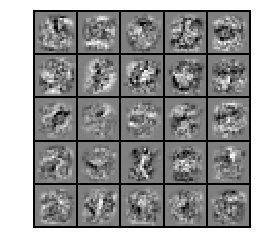

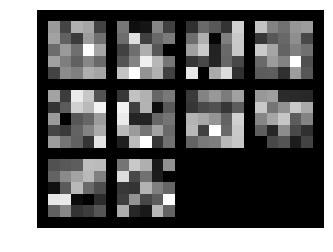

In [161]:
###   VISUALIZING THE FITTING PARAMETERS
###   One way to understand what your neural network is learning is to 
###   visualize what the representations captured by the hidden units. Informally, given a particular hidden unit,
##  In your trained network, you should ﬁnd that the hidden units corresponds roughly to detectors that look for
##  strokes and other patterns in the input.

a,b=displayData(grad1[:,1:])
a,b=displayData(grad2[:,1:])